In [23]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.integrate import simps
from scipy.signal import gaussian

from core.evolution import imaginary
from core.empirical import in_segregation

au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

In [24]:
def concentration(x0, R, ml):
    # 2 monolayers requires 100 surrounding
    # 20 monolayers requires 10 surrounding
    # but let's force at least 10
    nsl = max(10,int(110+(10-100/(20-2))*ml)) # number of surrounding layers (each side)
    
    tl = ml + 2 * nsl  # total layers
    # bulk before well
    x = [0] * nsl
    # well
    for n in range(1, ml+1):
        x.append(in_segregation(x0, R, n))
    # barrier after well
    for n in range(1, nsl+1):
        x.append(in_segregation(x0, R, n+ml, ml))
    return np.arange(1, len(x)+1), np.array(x)

In [25]:
x0     = 0.11 # intended indium concentration
R      = 0.85 # segregation parameter
N      = 1024 # number of grid points
offset = (0.7, 0.3)
ml     = 12 # number of monolayers

In [26]:
a0   = np.vectorize(lambda x:  6.08 *x+(1-x)*  5.650)
a    = np.vectorize(lambda x: -6.08 *x+(1-x)* -8.33 )
b    = np.vectorize(lambda x: -1.55 *x+(1-x)* -1.90 )
c11  = np.vectorize(lambda x:  0.83 *x+(1-x)*  1.22 )
c12  = np.vectorize(lambda x:  0.45 *x+(1-x)*  0.57 )

me   = np.vectorize(lambda x: 0.067*(1-0.426*x))
mhhz = np.vectorize(lambda x: 0.34 *(1+0.117*x))

[]

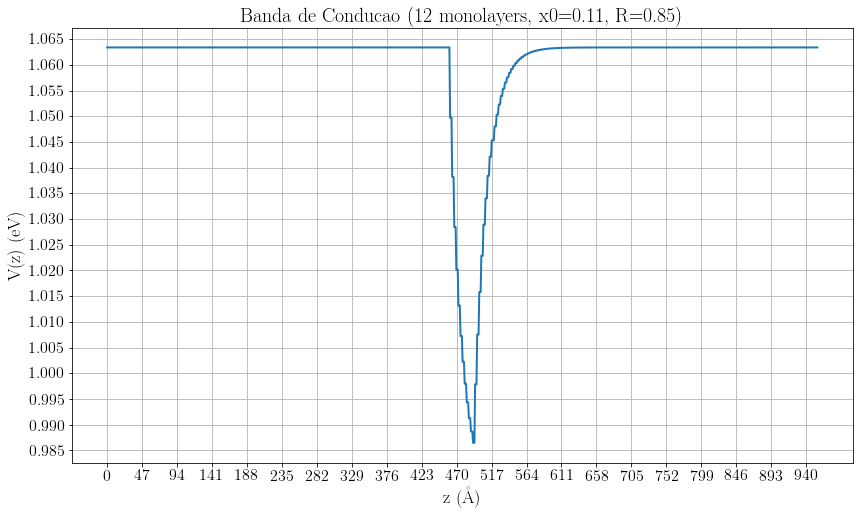

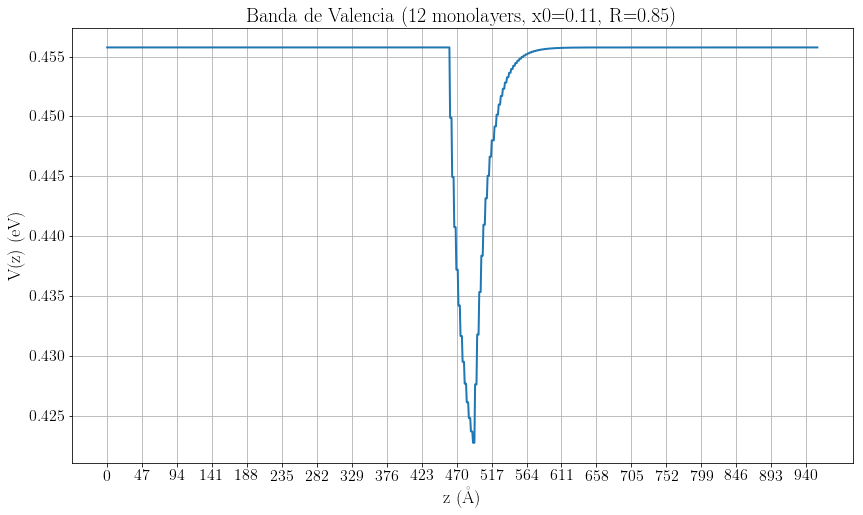

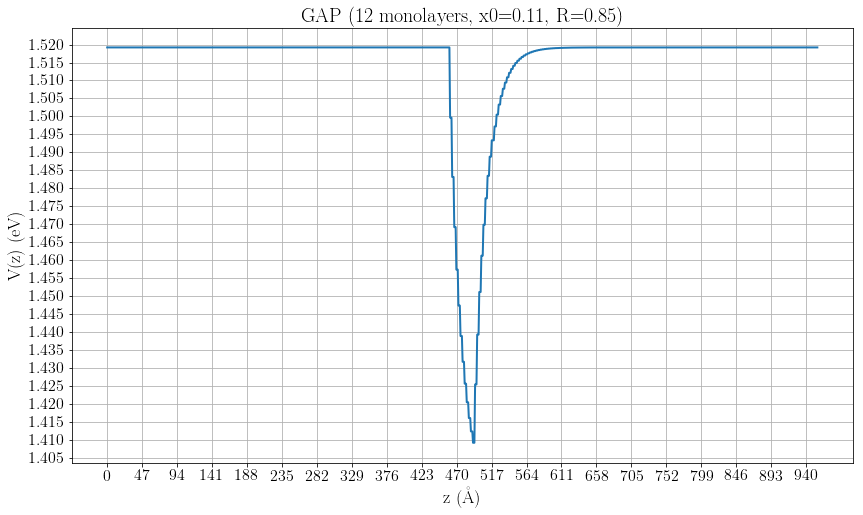

In [27]:
layers, in_x = concentration(x0, R, ml)

def concentration_z(z):
    position = 0.0
    for x, a in zip(in_x, a0(in_x)):
        position += a/2.0
        if z < position:
            return x
    return in_x[0]

z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
in_x_z = np.vectorize(concentration_z)(z)
gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)

_a   = a(in_x_z)
_b   = b(in_x_z)
_c11 = c11(in_x_z)
_c12 = c12(in_x_z)
_epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)

gap_strain = gap + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
gap_c      = offset[0] * gap_strain
gap_v      = offset[1] * gap_strain

fig = plt.figure()
ax  = fig.gca()
ax.set_yticks(np.arange(0, 2.0, 0.005))
ax.set_xticks(np.arange(0,  np.max(z), int(np.max(z)/20)))
ax.set_xlabel('z (\AA)')
ax.set_ylabel('V(z) (eV)')
ax.plot(z, gap_c)
plt.title("Banda de Conducao (%d monolayers, x0=%.2f, R=%.2f)"%(ml, x0, R))
plt.legend()
plt.grid(True)
plt.plot()

fig = plt.figure()
ax  = fig.gca()
ax.set_yticks(np.arange(0, 2.0, 0.005))
ax.set_xticks(np.arange(0,  np.max(z), int(np.max(z)/20)))
ax.set_xlabel('z (\AA)')
ax.set_ylabel('V(z) (eV)')
ax.plot(z, gap_v)
plt.title("Banda de Valencia (%d monolayers, x0=%.2f, R=%.2f)"%(ml, x0, R))
plt.legend()
plt.grid(True)
plt.plot()

fig = plt.figure()
ax  = fig.gca()
ax.set_yticks(np.arange(0, 2.0, 0.005))
ax.set_xticks(np.arange(0,  np.max(z), int(np.max(z)/20)))
ax.set_xlabel('z (\AA)')
ax.set_ylabel('V(z) (eV)')
ax.plot(z, gap_strain)
plt.title("GAP (%d monolayers, x0=%.2f, R=%.2f)"%(ml, x0, R))
plt.legend()
plt.grid(True)
plt.plot()

In [28]:
PL_nosso = []
infos_e  = []
infos_h  = []

z_au    = z/au2ang # angstrom to au
v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au

electron   = imaginary(z_au,v_e_au ,  me(in_x_z))
infos_e.append(electron)
heavy_hole = imaginary(z_au,v_hh_au, mhhz(in_x_z))
infos_h.append(heavy_hole)

Ee      = electron['eigenvalues'][0]* au2ev
Ce      = electron['counters'][0]
Pe      = electron['precisions'][0]
Te      = electron['timers'][0]
Se      = electron['squared_euclidean_dist'][0]
Ee_es   = electron['eigenstates'][0]

Ehh     = heavy_hole['eigenvalues'][0]* au2ev
Chh     = heavy_hole['counters'][0]
Phh     = heavy_hole['precisions'][0]
Thh     = heavy_hole['timers'][0]
Shh     = heavy_hole['squared_euclidean_dist'][0]
Ehh_es  = heavy_hole['eigenstates'][0]

gap_min = np.min(gap_strain)
pl = gap_min+Ehh+Ee-7e-3

print("ML={0:02d}, Ee={1:.8f}, Te={2:04.1f} s, Ehh={3:.8f}, Thh={4:04.1f} s, PL={5:.8f} eV".format(
    ml, Ee, Te, Ehh, Thh, pl))

#10 ML=02, Ee=0.03014778, Te=09.4 s, Ehh=0.01274512, Thh=34.5 s, PL=1.50281427 eV
#20 ML=02, Ee=0.03281196, Te=25.8 s, Ehh=0.01373311, Thh=87.3 s, PL=1.50646644 eV
#40 ML=02, Ee=0.03414217, Te=63.9 s, Ehh=0.01408080, Thh=125.2 s, PL=1.50814434 eV
#60 ML=02, Ee=0.03448416, Te=85.0 s, Ehh=0.01411553, Thh=109.9 s, PL=1.50852105 eV
#80 ML=02, Ee=0.03457996, Te=84.6 s, Ehh=0.01411052, Thh=109.0 s, PL=1.50861185 eV

ML=12, Ee=0.05616810, Te=24.0 s, Ehh=0.01986206, Thh=43.1 s, PL=1.47824784 eV


[]

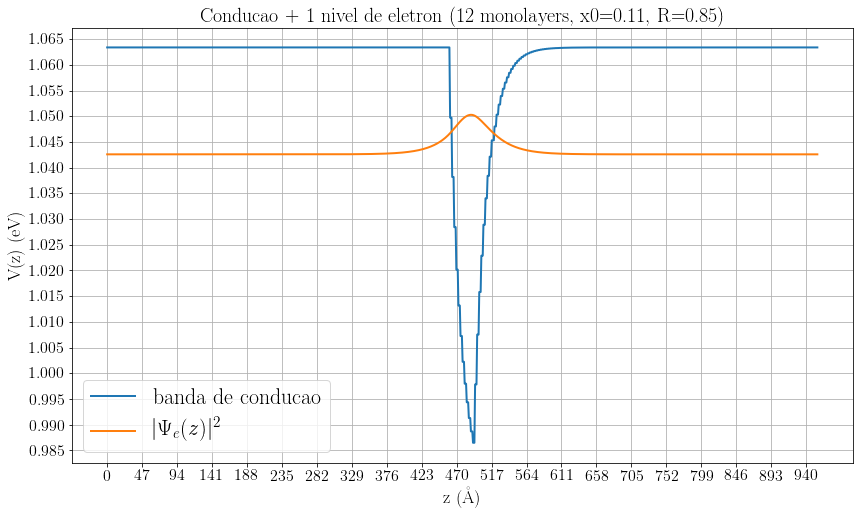

In [33]:
psi_e = np.abs(Ee_es)**2
psi_e *= (np.ptp(gap_c)/np.ptp(psi_e)) / 10
psi_e += Ee + np.min(gap_c)

fig = plt.figure()
ax  = fig.gca()
ax.set_yticks(np.arange(0, 2.0, 0.005))
ax.set_xticks(np.arange(0,  np.max(z), int(np.max(z)/20)))
ax.set_xlabel('z (\AA)')
ax.set_ylabel('V(z) (eV)')
ax.plot(z, gap_c, label='banda de conducao')
ax.plot(z, psi_e, label='$|\Psi_e(z)|^2$')
plt.title("Conducao + 1 nivel de eletron (%d monolayers, x0=%.2f, R=%.2f)"%(ml, x0, R))
plt.legend()
plt.grid(True)
plt.plot()

[]

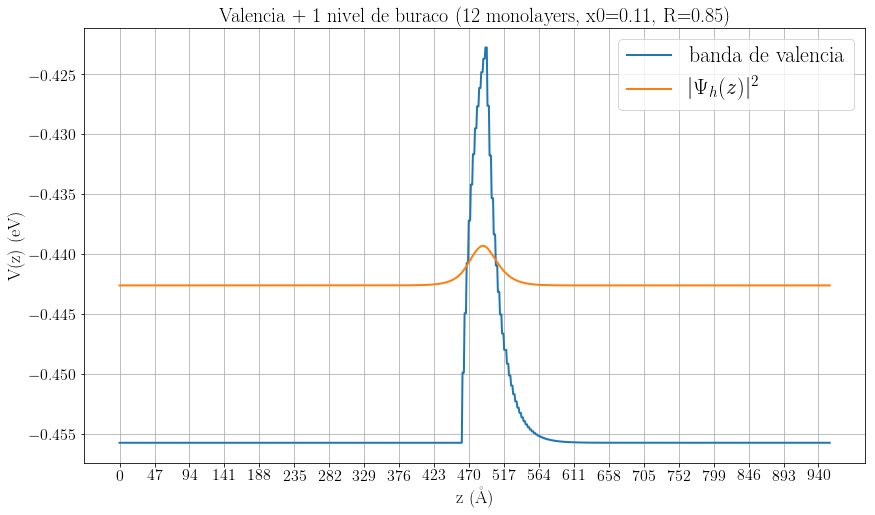

In [34]:
psi_h = np.abs(Ehh_es)**2
psi_h *= (np.ptp(gap_v)/np.ptp(psi_h)) / 10
psi_h += Ehh + np.min(gap_v)

fig = plt.figure()
ax  = fig.gca()
ax.set_yticks(np.arange(-2.0, 2.0, 0.005))
ax.set_xticks(np.arange(0,  np.max(z), int(np.max(z)/20)))
ax.set_xlabel('z (\AA)')
ax.set_ylabel('V(z) (eV)')
ax.plot(z, -gap_v, label='banda de valencia')
ax.plot(z, -(2*np.min(psi_h)-psi_h), label='$|\Psi_h(z)|^2$')
plt.title("Valencia + 1 nivel de buraco (%d monolayers, x0=%.2f, R=%.2f)"%(ml, x0, R))
plt.legend()
plt.grid(True)
plt.plot()

[]

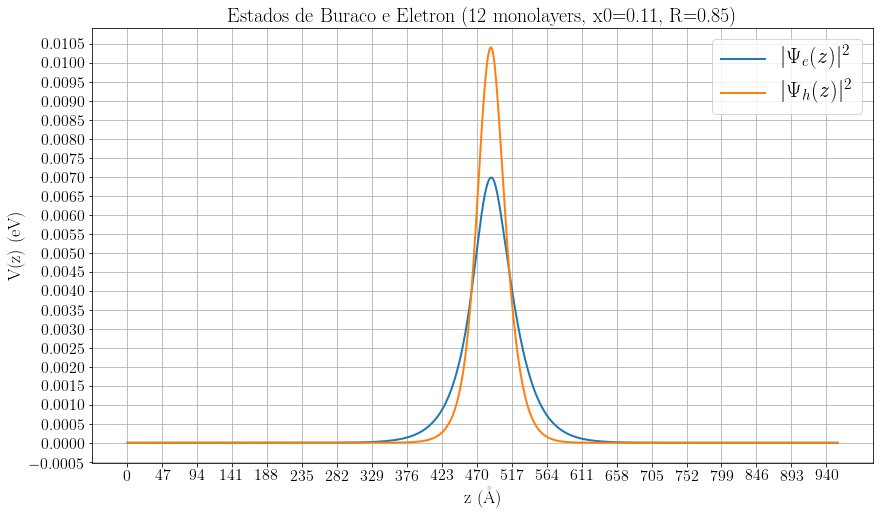

In [35]:
psi_se = np.abs(Ee_es)**2
psi_sh = np.abs(Ehh_es)**2

fig = plt.figure()
ax  = fig.gca()
ax.set_yticks(np.arange(-0.1, 0.1, 0.0005))
ax.set_xticks(np.arange(0,  np.max(z), int(np.max(z)/20)))
ax.set_xlabel('z (\AA)')
ax.set_ylabel('V(z) (eV)')
ax.plot(z, psi_se, label='$|\Psi_e(z)|^2$')
ax.plot(z, psi_sh, label='$|\Psi_h(z)|^2$')
plt.title("Estados de Buraco e Eletron (%d monolayers, x0=%.2f, R=%.2f)"%(ml, x0, R))
plt.legend()
plt.grid(True)
plt.plot()

In [38]:

# envelope  = Ee_es + Ehh_es
# envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
# z_med     = simps(envelope.conj()*z*envelope,z)

Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)

idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
gap_min = gap_strain[idx]
pl = gap_min+Ehh+Ee-7e-3
print(pl)

1.48140645254


In [ ]:
1.48140645254